In [14]:
import numpy as np
import cantera as ct 
import matplotlib.pyplot as plt

In [15]:
file = '/home/vasily/Projects/empirica_traveling_flame/chemistry/mechanisms/merino_66_mech/Skeletal_66-SD_20161214.yaml'


In [16]:
sol_mech = ct.Solution(file)

/tmp/ipykernel_16474/1228782169.py:1: UserWarning: NasaPoly2::validate: 
For species CH2CH2OH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  15.107838949
	Value computed using high-temperature polynomial: 15.385775331099998

  sol_mech = ct.Solution(file)
/tmp/ipykernel_16474/1228782169.py:1: UserWarning: NasaPoly2::validate: 
For species CH2CH2OH, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  4.688575616966668
	Value computed using high-temperature polynomial: 4.64839243407

  sol_mech = ct.Solution(file)
/tmp/ipykernel_16474/1228782169.py:1: UserWarning: NasaPoly2::validate: 
For species CH3CHOH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  14.825843632999998
	Value computed using high-temperature polynomial: 15.109926177800002

  sol_mech = ct.Solution(file)
/tmp/ipykernel_16474/1228782169.py:1: UserWarning: NasaPoly2::validate: 
F

In [296]:
# r = ct.Reaction({"C2H5OH": 1, "O2" : 3}, {"CO2" : 2, "H2O" : 3}, rate=ct.ArrheniusRate(10000000000000, 0, 100), orders=)

r = ct.Reaction(equation="C2H5OH + 3 O2 => 2 CO2 + 3 H2O", rate=ct.ArrheniusRate(1000000000000, 0, 1000000))
r.orders={
    "C2H5OH" : 2,
    "O2" : 1
}
sol_onestep = ct.Solution(thermo='ideal-gas', kinetics='gas',
                  species=sol_mech.species(), reactions=[r], name='my_custom_name')

/tmp/ipykernel_16474/952511137.py:1: UserWarning: NasaPoly2::validate: 
For species CH2CH2OH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  15.107838949
	Value computed using high-temperature polynomial: 15.385775331099998

  sol_onestep = ct.Solution(thermo='ideal-gas', kinetics='gas',
/tmp/ipykernel_16474/952511137.py:1: UserWarning: NasaPoly2::validate: 
For species CH2CH2OH, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  4.688575616966668
	Value computed using high-temperature polynomial: 4.64839243407

  sol_onestep = ct.Solution(thermo='ideal-gas', kinetics='gas',
/tmp/ipykernel_16474/952511137.py:1: UserWarning: NasaPoly2::validate: 
For species CH3CHOH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  14.825843632999998
	Value computed using high-temperature polynomial: 15.109926177800002

  sol_onestep = ct.Solution(thermo='ideal-

In [307]:
Y_air_N2= 0.767
Y_air_O2= 0.233
Y_fuel = 0.02

In [312]:
from scipy.stats import qmc

In [372]:
rng = np.random.default_rng()

radius = 0.2

engine = qmc.PoissonDisk(d=2, radius=radius, rng=rng)

sample = engine.random(int(1./(radius**4)))

TYs = sample.copy()
TYs[:, 0] = TYs[:, 0]*400 + 1200
TYs[:, 1] = TYs[:, 1]*0.08

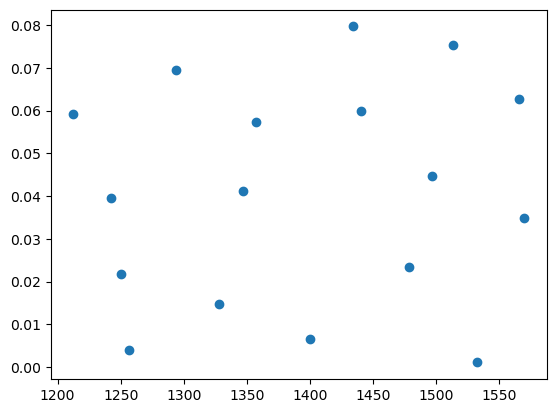

In [373]:
plt.scatter(TYs[:, 0], TYs[:, 1])

In [478]:
def model(gas, T, Y_fuel):
    gas.TPY = T, 1e5, {"N2" : Y_air_N2 * (1-Y_fuel), "O2" : Y_air_O2 * (1-Y_fuel), "C2H5OH" : Y_fuel} 
    r = ct.IdealGasConstPressureReactor(gas)
    # r = ct.Reactor(name='adiabatic_reactor', contents=gas)
    sim = ct.ReactorNet([r])
    # time = 0.0
    states = ct.SolutionArray(gas, extra=['t', 'maxrate'])
    max_sim_time = 0.01
    while sim.time < max_sim_time:
        # print(sim.time) 
        # if fixed_iter is not None:
        #     sim.advance(sim.time + (max_sim_time/fixed_iter))
        # else:
        sim.step()
        states.append(r.thermo.state, t=sim.time, maxrate=np.max(np.abs(gas.net_production_rates)))
    return states

In [479]:
states_m_TY = []
for T, Y_fuel in TYs:
    states_m_TY.append(model(sol_mech, T, Y_fuel))

In [480]:
def err_func(x):
    lnA, lnE = x
    r = ct.Reaction(equation="C2H5OH + 3 O2 => 2 CO2 + 3 H2O", rate=ct.ArrheniusRate(np.exp(lnA), 0, np.exp(lnE)))
    r.orders={
        "C2H5OH" : 2,
        "O2" : 1
    }
    sol_onestep = ct.Solution(thermo='ideal-gas', kinetics='gas',
                    species=sol_mech.species(), reactions=[r], name='my_custom_name')
    err = 0
    # states_m_TY = []
    for i, (T, Y_fuel) in enumerate(TYs):
        state = model(sol_onestep, T, Y_fuel)
        err +=  np.mean(np.power(np.interp(states_m_TY[i].t, state.t, state.T), 2) - states_m_TY[i].T)
        
    return np.sqrt(err / len(TYs))

In [481]:
init = np.log(1000000000000), np.log(100000)

In [482]:
import scipy.optimize

In [483]:
sol = scipy.optimize.minimize(err_func, init, 
                              tol=1e-10, 
                            #   method="Nelder-Mead"
                              )

/tmp/ipykernel_16474/545943440.py:8: UserWarning: NasaPoly2::validate: 
For species CH2CH2OH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  15.107838949
	Value computed using high-temperature polynomial: 15.385775331099998

  sol_onestep = ct.Solution(thermo='ideal-gas', kinetics='gas',
/tmp/ipykernel_16474/545943440.py:8: UserWarning: NasaPoly2::validate: 
For species CH2CH2OH, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  4.688575616966668
	Value computed using high-temperature polynomial: 4.64839243407

  sol_onestep = ct.Solution(thermo='ideal-gas', kinetics='gas',
/tmp/ipykernel_16474/545943440.py:8: UserWarning: NasaPoly2::validate: 
For species CH3CHOH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  14.825843632999998
	Value computed using high-temperature polynomial: 15.109926177800002

  sol_onestep = ct.Solution(thermo='ideal-

In [484]:
sol.x

array([27.63102112, 11.51292546])

In [485]:
sol

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 2154.9094483849735
        x: [ 2.763e+01  1.151e+01]
      nit: 0
      jac: [ 5.097e+01 -8.812e-01]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 71
     njev: 20

In [486]:
init

(np.float64(27.631021115928547), np.float64(11.512925464970229))

In [487]:
lnA, lnE = sol.x
r = ct.Reaction(equation="C2H5OH + 3 O2 => 2 CO2 + 3 H2O", rate=ct.ArrheniusRate(np.exp(lnA), 0, np.exp(lnE)))
r.orders={
    "C2H5OH" : 2,
    "O2" : 1
}
sol_onestep = ct.Solution(thermo='ideal-gas', kinetics='gas',
                species=sol_mech.species(), reactions=[r], name='my_custom_name')

/tmp/ipykernel_16474/4217686234.py:7: UserWarning: NasaPoly2::validate: 
For species CH2CH2OH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  15.107838949
	Value computed using high-temperature polynomial: 15.385775331099998

  sol_onestep = ct.Solution(thermo='ideal-gas', kinetics='gas',
/tmp/ipykernel_16474/4217686234.py:7: UserWarning: NasaPoly2::validate: 
For species CH2CH2OH, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  4.688575616966668
	Value computed using high-temperature polynomial: 4.64839243407

  sol_onestep = ct.Solution(thermo='ideal-gas', kinetics='gas',
/tmp/ipykernel_16474/4217686234.py:7: UserWarning: NasaPoly2::validate: 
For species CH3CHOH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  14.825843632999998
	Value computed using high-temperature polynomial: 15.109926177800002

  sol_onestep = ct.Solution(thermo='ide

In [490]:
T = 1800
states_m = model(sol_mech, T, Y_fuel)
states_os = model(sol_onestep, T, Y_fuel)

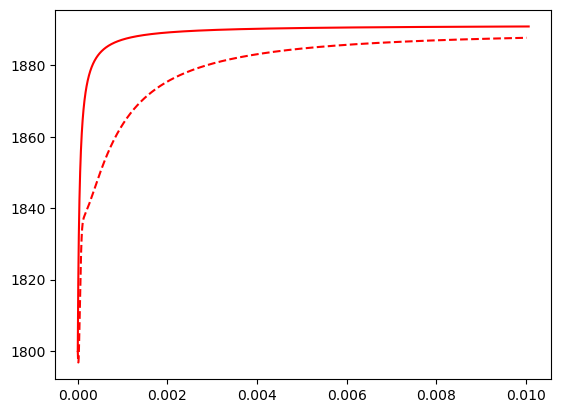

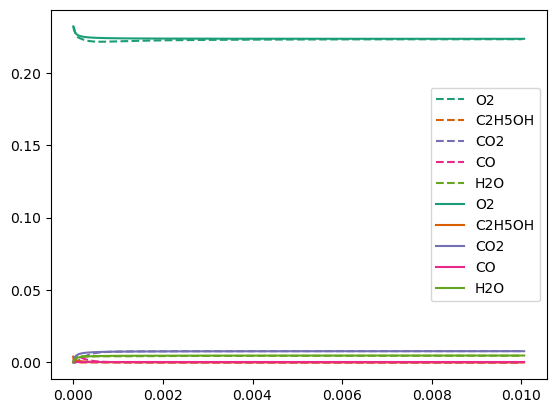

In [491]:
plt.plot(states_m.t, states_m.T, '--', c="r")
plt.plot(states_os.t, states_os.T, c="r")

plt.figure()
spns = ["o2", "c2h5oh",  "co2", "co", "h2o"]

cs = plt.cm.Dark2(list(range(len(spns))))



for j, i in enumerate(spns):
    i = str(i).upper()
    plt.plot(np.array(states_m.t),  np.array(states_m.Y)[:, sol_mech.species_index(i)], "--", label=i, c=cs[j])

for j, i in enumerate(spns):
    i = str(i).upper()
    plt.plot(np.array(states_os.t),  np.array(states_os.Y)[:, sol_onestep.species_index(i)], label=i, c=cs[j])
plt.legend()
